/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


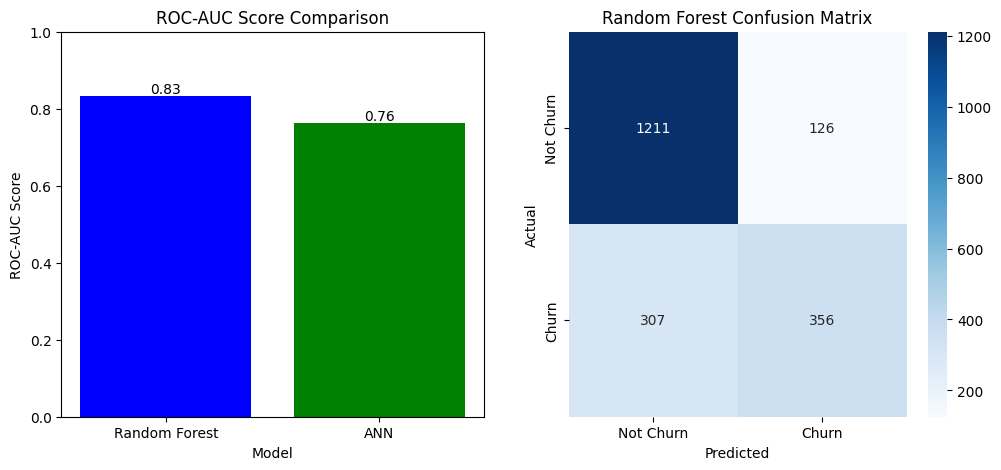

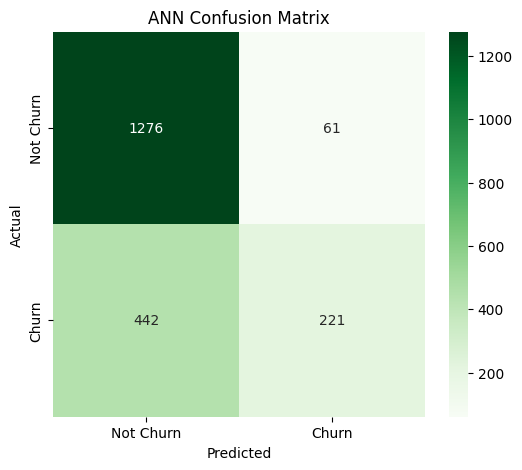

Random Forest ROC-AUC Score: 0.8318560609906468
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.91      0.85      1337
           1       0.74      0.54      0.62       663

    accuracy                           0.78      2000
   macro avg       0.77      0.72      0.74      2000
weighted avg       0.78      0.78      0.77      2000

Random Forest Confusion Matrix:
 [[1211  126]
 [ 307  356]]
ANN ROC-AUC Score: 0.7621546403498975
ANN Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.95      0.84      1337
           1       0.78      0.33      0.47       663

    accuracy                           0.75      2000
   macro avg       0.76      0.64      0.65      2000
weighted avg       0.76      0.75      0.71      2000

ANN Confusion Matrix:
 [[1276   61]
 [ 442  221]]


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras

# Load dataset
file_path = "/content/Pakistan Largest Ecommerce Dataset.csv"
df = pd.read_csv(file_path, low_memory=False)

# Data Preprocessing
df = df[['status', 'price', 'qty_ordered', 'grand_total', 'discount_amount', 'payment_method', 'category_name_1', 'Year', 'Month']]
df.dropna(inplace=True)

# Encode categorical features
le = LabelEncoder()
df['status'] = df['status'].apply(lambda x: 1 if x in ['canceled', 'order_refunded'] else 0)
df['payment_method'] = le.fit_transform(df['payment_method'])
df['category_name_1'] = le.fit_transform(df['category_name_1'])

# Split dataset
X = df.drop(columns=['status'])
y = df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Evaluate Random Forest
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
rf_report = classification_report(y_test, y_pred_rf)

# Train Deep Learning Model
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate ANN
y_prob_ann = model.predict(X_test).flatten()
y_pred_ann = (y_prob_ann > 0.5).astype(int)
roc_auc_ann = roc_auc_score(y_test, y_prob_ann)
conf_matrix_ann = confusion_matrix(y_test, y_pred_ann)
ann_report = classification_report(y_test, y_pred_ann)

# Visualization of Model Performance
plt.figure(figsize=(12, 5))

# ROC-AUC Comparison
plt.subplot(1, 2, 1)
bars = plt.bar(['Random Forest', 'ANN'], [roc_auc_rf, roc_auc_ann], color=['blue', 'green'])
plt.xlabel("Model")
plt.ylabel("ROC-AUC Score")
plt.title("ROC-AUC Score Comparison")
plt.ylim(0, 1)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')

# Confusion Matrix Heatmaps
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_ann, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.title("ANN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Print Evaluation Metrics
print("Random Forest ROC-AUC Score:", roc_auc_rf)
print("Random Forest Classification Report:\n", rf_report)
print("Random Forest Confusion Matrix:\n", conf_matrix_rf)

print("ANN ROC-AUC Score:", roc_auc_ann)
print("ANN Classification Report:\n", ann_report)
print("ANN Confusion Matrix:\n", conf_matrix_ann)
